In [1161]:
from numpy import *
from scipy import *
import numpy as np
from matplotlib import *

from scipy import integrate
from scipy import interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import xlrd
import xlsxwriter

rc('text',usetex = True)
rc('font', family='serif',size = 12)

In [2]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
Eff = Data.sheet_by_name('Eff')


Effect = []

for i in range(7):
     Effect.append(array(Eff.col_values(i)))

phi = np.arange(0.1,2.01,0.1)
NTU = np.arange(50,351,50)
NN,PP = np.meshgrid(NTU,phi)
Effectiv = interpolate.interp2d(phi,NTU,Effect,kind = 'linear')

In [3]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
HEx = Data.sheet_by_name('HEx_Cold')

m_f_HEx_c   = array(HEx.col_values(0)) 
Ec_HEx_c   = array(HEx.col_values(1)) 
W_T_HEx_c   = array(HEx.col_values(2)) 
W_f_HEx_c   = array(HEx.col_values(3)) 
W_p_HEx_c   = array(HEx.col_values(4)) 

In [4]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
HEx = Data.sheet_by_name('HEx_Hot')

m_f_HEx_h   = array(HEx.col_values(0)) 
Ec_HEx_h   = array(HEx.col_values(1)) 
W_T_HEx_h   = array(HEx.col_values(2)) 
W_f_HEx_h   = array(HEx.col_values(3)) 
W_p_HEx_h   = array(HEx.col_values(4)) 

def HEx_Power(m_f_HEx,W_T_HEx,W_f_HEx,W_p_HEx,Ec_HEx,m_f,ECr):
    A = 0
    B = 9
    
    for i in range(len(m_f_HEx)-1):
        if np.round(m_f,4) == np.round(m_f_HEx[i],4) and np.round(m_f,4) < np.round(m_f_HEx[i+1],4):
            B = i
            #print(B)
            break
    print(B,m_f,m_f_HEx[B],m_f_HEx[B+1])
    for i in range(B,0,-1):
        if m_f_HEx[i] == m_f_HEx[B]:
            A = i
        else:
            break
    print(A,B,m_f_HEx[A],m_f_HEx[B])
    C = len(Ec_HEx)-1
    D = len(Ec_HEx)-1
    for i in range(A,B):
        print(i,C)
        if abs(ECr-Ec_HEx[i]) < abs(ECr-Ec_HEx[C]) and ECr < Ec_HEx[i]:
            C = i
            #print('oic',C)
    for i in range(B,A,-1):
        print(i,D)
        if abs(ECr-Ec_HEx[i]) < abs(ECr-Ec_HEx[D]) and ECr > Ec_HEx[i]:
            D = i
            #print('oid',D)
    print(C,D,Ec_HEx[C],Ec_HEx[D])
    W_T = W_T_HEx[C]+(W_T_HEx[D]-W_T_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])
    W_f = W_f_HEx[C]+(W_f_HEx[D]-W_f_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])
    W_p = W_p_HEx[C]+(W_p_HEx[D]-W_p_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])          
    return(W_T,W_f,W_p)

In [5]:
def HEx_Power(m_f_HEx,W_T_HEx,W_f_HEx,W_p_HEx,Ec_HEx,m_f,ECr):
    A = 0
    B = 9
    
    for i in range(len(m_f_HEx)-1):
        if np.round(m_f,4) == np.round(m_f_HEx[i],4) and np.round(m_f,4) < np.round(m_f_HEx[i+1],4):
            B = i
            #print(B)
            break
    #print(B,m_f,m_f_HEx[B],m_f_HEx[B+1])
    for i in range(B,0,-1):
        if m_f_HEx[i] == m_f_HEx[B]:
            A = i
        else:
            break
    #print(A,B,m_f_HEx[A],m_f_HEx[B])
    C = len(Ec_HEx)-1
    D = len(Ec_HEx)-1
    Ref_C = 1
    Ref_D = 0
    for i in range(A,B):
        #print(i,C)
        if abs(ECr-Ec_HEx[i]) < abs(ECr-Ref_C) and ECr < Ref_C:
            C = i
            Ref_C = Ec_HEx[i]
            #print('oic',C)
    for i in range(B,A,-1):
        #print(i,D)
        if abs(ECr-Ec_HEx[i]) < abs(ECr-Ref_D) and ECr > Ref_D:
            D = i
            Ref_D = Ec_HEx[i]
            #print('oid',D)
    #print(C,D,Ec_HEx[C],Ec_HEx[D])
    W_T = W_T_HEx[C]+(W_T_HEx[D]-W_T_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])
    W_f = W_f_HEx[C]+(W_f_HEx[D]-W_f_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])
    W_p = W_p_HEx[C]+(W_p_HEx[D]-W_p_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])          
    return(W_T,W_f,W_p)

In [6]:
def Radius(X): 
    R2,R3,B,L_m,L_r,h = X
    #return (1.41634776*(R2**-1.10684344)*(R3**2.08169412)*(B**0.74232364))
    #return((B/((0.7390256*R2**1.49668268*R3**-2.71694101)*1.025343*np.exp(-33.1224/L_m)*(-6.66110174/32*(L_r/L_m)**3 + 2.67069441/12*(L_r/L_m)**2 - 0.50770413/4*(L_r/L_m) + 1.00892496)))**(1/1.23379933))
    #return((B/((0.74794602381*R2**1.50307868*R3**-2.73422634)*1.025343*np.exp(-33.1224/L_m)*(-6.66110174/32*(L_r/L_m)**3 + 2.67069441/12*(L_r/L_m)**2 - 0.50770413/4*(L_r/L_m) + 1.00892496)))**(1/1.240075))
    A1 = ((B/((0.74794602381*R2**1.50307868*R3**-2.73422634)*1.025343*np.exp(-33.1224/L_m)*(-6.66110174/32*(L_r/L_m)**3 + 2.67069441/12*(L_r/L_m)**2 - 0.50770413/4*(L_r/L_m) + 1.00892496)))**(1/1.240075))
    #A2 = (B/((0.99497192*R2**1.55620764*R3**(-2.77937455))*np.exp(-0.92376442*(R3-R2)/L_m)*(h**0.08060702)*(-6.66110174/32*(L_r/L_m)**3 + 2.67069441/12*(L_r/L_m)**2 - 0.50770413/4*(L_r/L_m) + 1.00892496)))**(1/1.1223844)
    A2 = (B/((1.71951251*R2**2.10853942*R3**(-3.7047729))*np.exp(-19.28562192/L_m)*(h**0.06469294)*(-6.66110174/32*(L_r/L_m)**3 + 2.67069441/12*(L_r/L_m)**2 - 0.50770413/4*(L_r/L_m) + 1.00892496)))**(1/1.38270461)
    return(A2)

In [7]:
def MagField(X,a,b,c,d,e,f):
    R2,R3,R4,h,L,B_rem = X
    return (a*(B_rem)*(R2**b)*(R3**c)*(R4**d)*(np.exp(e*(R3-R2)/L))*(h**f))

In [8]:
def MField(X,a,b,c,d,e):
    V_gap,V_mag,V_out,L,B_rem,R_4 = X
    return (a*(B_rem)*((V_gap/V_mag)**b)*(np.exp(c*R_4/L))*(np.tanh(d*(V_out/V_mag))+e))

In [9]:
def MField_2(X,a,b,c,d,e,f,g):
    R2,R3,R4,L,B_rem,R5 = X
    return (a*(B_rem)*(R2**b)*(R3**c)*(R4**d)*(np.exp(e*(R3-R2)/L))*(np.tanh(f*(R5**2-R4**2)/(R4**2-R3**2))+g))

In [454]:
def Qc(X): 
    P1,P2,P3,P4,P5= X #Q_pas_CB,Q_act_CB,Q_span,W_mag,W_p
    #return( 0.44774473*P1+0.69113695*P2-0.46543184*P3+0.02740828*P4-1.2412753 *P5)
    #return(0.271043*P1+0.49653155*P2-0.28565907*P3+1*P4-1.13502211*P5)
    #return(0.66679759*P1 +  0.8505155*P2 -0.6893551*P3 -0.94156247*P4-0.34938015*P5)
    return(0.59410225*P1+  0.88061713*P2 -0.62088895*P3 -1*P4         -0.34465627*P5)

In [455]:
def Qh(X): 
    P1,P2,P3,P4,P5= X
    #return(0.46673225*P1+1.40322589*P2-0.49908018*P3+0.01575257*P4-0.68914607*P5)
    #return(0.36735687*P1+1*P2-0.38713269*P3+1*P4-0.21881993*P5)
    #return(0.77855664*P1+ 1.44966907*P2 -0.80985607*P3+ 0.39133248*P4+  0.65808892*P5)
    return(0.71673365*P1 + 1.42540766*P2 -0.74956013*P3  + 0.63910187*P4 + 0.64031711*P5)

def W_m(X):
    P1,P2,P3 = X
    #a = 0.00541105
    #a = 0.00937193
    a = 2.89392107e-03
    
    #b = -2.21029128
    #b = -0.99809109
    b = -3.14070133e+00
    
    #c = 2.84461382
    #c = 4.33008264
    c = 3.20699560e+00
    
    #d = 2.85861479
    #d = 1.61088792
    d = 3.81307556e+00
    
    return(a*P1**b*P2**c*P3**d )

In [403]:
def W_m(P1,P2,P3,m_s,f):
    
    a = -4.24746211e-05
    b = 8.59623501e-01
    c = 3.06311253e-05
    d = 8.29382882e-01,
    e = 6.04968831e-01,
    
    return (m_s*f*P3*(a*P1**b+c*(P2)**d)*P3**e)

In [404]:
def W_Hex(X):
    P1,P2 = X
    return (a*P1**b + c*P2**d)

In [405]:
def Prop_param(X):
    T_c,T_h,B = X
    C_H = 1.65161038/100*T_c+2.59946197*T_h-1.14324309*100*B
    C_L = 10.16443738*T_c-5.32568341*T_h-0.71305997*B
    dT_mg = -0.01057708*T_c+0.01163704*T_h+1.73509682*B
    dT_dmg = -0.01229483*T_c+0.01376157*T_h+0.76454655*B
    CdT_mg = -9.517569*T_c+11.49711993*T_h+820.04168503*B
    CdT_dmg = 4.39480124*T_c-7.07931118/10*T_h+9.15928168*100*B
    return(C_H,C_L,dT_mg,dT_dmg,CdT_mg,CdT_dmg)

In [406]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx') #Import inputs File
Inputs = Data.sheet_by_name('Data') 

L   = array(Inputs.col_values(0)) #Import AMR Length [mm]
H   = array(Inputs.col_values(1)) #Import AMR Height [mm]
W   = array(Inputs.col_values(2)) #Import AMR Width [mm]
T_c = array(Inputs.col_values(3))+273.15 #Import temperature span [K]
T_h = array(Inputs.col_values(4))+273.15 #Import temperature span [K]
B   = array(Inputs.col_values(5)) #Import magnetic field [T]
f   = array(Inputs.col_values(6)) #Import frequency [Hz]
m_f = array(Inputs.col_values(7))/3600 #Import mass flow rate [kg/h]
Q_c = array(Inputs.col_values(8)) #Import Cooling capacity [W]
Q_h = array(Inputs.col_values(9)) #Import Rejected heat [W]
W_p = array(Inputs.col_values(10)) #Import Pumping power [W]
W_ma = array(Inputs.col_values(11)) #Import Magnetic power [W]
T_c_ml = array(Inputs.col_values(12))+273.15 #Import temperature span [K]
T_h_ml = array(Inputs.col_values(13))+273.15 #Import temperature span [K]


Calculation

In [463]:
def Optimal(m_f,FE,f,L,H,W,B,Tc,Th,Tce,The,L_xt,h_f):
    
    ##Properties of the solid 
    #rho_s = 7900  #[kg/m3] Density of the solid
    #k_s   = 8 #[W/(m2.K)] #Thermal conductivity of the solid

    ## Propertis of the fluid
    #rho_f = 1000  #[kg/m3] Density of the fluid
    #c_f   = 4181  #[kJ/(kg.K)] # Specific heat of the fluid
    #Pr_f  = 6.136 #[-] Prandtl of the fluid
    #mu_f  = 0.00061 #0.0008901 #[kg/m-2] #Viscosity of the fluid
    #k_f   = 0.6065  #[W/(m2.K)] #Thermal conductivity of the fluid

    ## Porous medium
    #d_p = 500*10**(-6) #[m] Particle diameter
   
    #Epsilon = 0.45 #0.55  #[-] Porosity
    #Epsilon_dp = 0.36 #0.465 #[-] Porosity
    d_ph = (2/3)*Epsilon_dp/(1-Epsilon_dp)*d_p #290*10**(-6) #[m] Particle diameter
        
    #Magnetic Circuit
    #B_rem = 1.43
    #N_p = 2
    #N_Rp = 2
    
    ### CALCULATION ###
    
    #Porous medium
    
    t_h = 4
    t_w = 2.5
    N_reg = 4/FE
    
    #Regenerador Quadrad
    R2 = [W/2+t_w]/np.tan(np.pi/N_reg)-t_h
    R3 = np.sqrt((W/2)**2 + (R2+t_h+H)**2)+t_h
    
   
    
    #R_aux = np.sqrt((R2+t_h)**2-(W/2)**2)
    #R3 = np.sqrt((H+8+R_aux)**2+(W/2)**2)
    
    #Regenerador Circular
    
    #R_med = (4/FE)/(2*np.pi)*(W + 2*t_w)
    #R2 = R_med-(H/2+t_h)
    #R3 = R_med+(H/2+t_h)
    
    #A_st = H*W
    #A_aux_st = ((2*np.pi/(4/FE)-4*t_w/(R2+R3))/2)*((R3-t_h)**2-(R2+t_h)**2)
    A_aux_st = (np.pi/(4/FE))*((R3-t_h)**2-(R2+t_h)**2) - 2*t_w*((R3-t_h)-(R2+t_h))
    A_st = A_aux_st[0]
    

    m_s   = L*A_st*10**-9*(1-Epsilon)*rho_s #mass of the AMR

    Beta = (1-Epsilon)*6/d_p
    v_s   = (m_f)/(rho_f*A_st*10**-6) #Superficial velocity

    #Dimensionless Numbers
    Re_dp = d_p*v_s*rho_f/(mu_f) #Reynolds number
    Nu = 2*(1+4*(1-Epsilon_dp)/Epsilon_dp)+((1-Epsilon_dp)**0.5)*Re_dp**0.6*Pr_f**(1/3) # Nusselt number
    Pe = Re_dp*Pr_f
    h_int = Nu*k_f/d_p
    NTU_f  = h_int*Beta*(L*A_st*10**(-9))/(m_f*c_f) 
    #print(Re_dp)
    dP = (L/1000)*(150*(1-Epsilon_dp)**2*mu_f*v_s/(Epsilon_dp**3*d_p**2) + 1.75*(1-Epsilon_dp)*rho_f*v_s**2/(Epsilon_dp**3*d_p))
    
    #dP = 0.5*413.11*(v_s*d_ph*rho_f/mu_f)**-0.514*rho_f*v_s**2*(L/1000)/d_ph
    #print(dP/dP_1)
    
    #Effective conduction
    #k_e_f = k_f*Epsilon #Fluid effective conduction

    #a_0 = exp(-1.084-6.778*(Epsilon-0.298))
    #f_0 = 0.8
    #k_e_s = k_f*((1-a_0)*(Epsilon*f_0+(1-Epsilon*f_0)*k_s/k_f)/(1-Epsilon*(1-f_0)+k_s/k_f*Epsilon*(1-f_0))+a_0*(2*((k_s/k_f)**2)*(1-Epsilon)+(1+2*Epsilon)*k_s/k_f)/((2+Epsilon)*k_s/k_f+(1-Epsilon))) #Solid effective conduction

    #D_ = (k_f*rho_f/c_f)*0.75*Pe/2

    #k_s_eff = k_e_s
    #k_f_eff = k_e_f + rho_f*c_f*D_
    
    ##### Properties Calculation ######   
    C_H,C_L,dT_mg,dT_dmg,CdT_mg,CdT_dmg = Prop_param((Tce,The,B))

    ##### Porous media effectivness #####

    C_HB = ((m_f)*c_f)/(m_s*C_L*f)
    C_CB = ((m_f)*c_f)/(m_s*C_H*f)

    Efness_HB = Effectiv(C_HB/2,NTU_f)
    Efness_CB = Effectiv(C_CB/2,NTU_f)

    #print(Efness_HB,Efness_CB,h_int,Nu,v_s,Re_dp)


    ## Metrics ##
    Pi_4 = CdT_mg/CdT_dmg
    Pi_6 = ((m_f)*c_f)/(m_s*C_L*f)
    Pi_11 = ((m_f)*c_f)/(m_s*C_H*f)
    Pi_15 = (C_L-C_H)*(The-Tce)
    
    Q_pas_CB = Efness_CB*(The - Tce)*m_f*FE*c_f
    Q_act_CB = dT_mg*m_f*c_f*FE

    Q_pas_HB = Efness_HB*(The - Tce)*m_f*FE*c_f
    Q_act_HB = dT_dmg*m_f*c_f*FE

    Q_span = (The - Tce)*m_f*c_f*FE
    #Q_cond = ((1-Epsilon)*k_s_eff + Epsilon*k_f_eff)*(W*H*10**-6)*(The-Tce)/L
    W_mag  = m_s*f*(CdT_mg - CdT_dmg)
    W_mag = W_m(Pi_6,Pi_11,Pi_15,m_s,f)
    W_pump = dP*m_f/rho_f*2*(FE)
    #print(Q_pas_CB,Q_act_CB,Q_span,W_mag,W_pump)

    ######Calculation#######
    
    FL = (0.45238549*(1+L_xt)**3-2.34797947*(1+L_xt)**2 +4.06737728*(1+L_xt)-1.44601011)*R2**-0.14716104*R3**(0.15172723)
    
    Qc_reg = Qc((Q_pas_CB,Q_act_CB,Q_span,W_mag,W_pump))*FL
    Qh_reg = Qh((Q_pas_HB,Q_act_HB,Q_span,W_mag,W_pump))*FL
    #print(Qc_reg,Qh_reg)
    #N_reg = Qc_target/Qc_reg
    Qc_target = Qc_reg*N_reg 
    Qh_target = Qh_reg*N_reg

    ECr_c = Qc_target/(FE*N_reg*m_f*c_f*(Tc-Tce))
    ECr_h = Qh_target/(FE*N_reg*m_f*c_f*(The-Th))
    
    B_rem = 1.43
    

    R4 = Radius((R2,R3,B/B_rem,L*(1+L_xt),L,h_f))
    

    
    #print(m_s,f,CdT_dmg,((Pi_6,Pi_4,Pi_11)))
    

    
    return (Qc_target,ECr_c,ECr_h,R4,R3,R2,W_mag,W_pump,Qh_target,L_xt,FL)

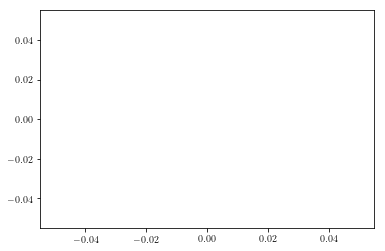

In [464]:
plt.plot(dp_p,m_p,'x')

In [1419]:
m_f = np.arange(700,1000,5)/3600
FE  = np.arange(25/100,30/100,5/100) 
f = np.arange(3,3.1,0.5)
L = np.arange(130,156,3)
H = np.arange(17,24,2)
W = np.arange(33,40,2)
B_max = np.arange(1.48,1.58,0.03)
Tce = np.arange(14,16,2)
The = np.arange(43,45,2)
L_xt = np.arange(0.15,0.26,0.02)
d_par = np.arange(500*10**-6,501*10**-6,100*10**-6)
h_f = np.arange(25,29,5)
#d_par = [500*10**-6]

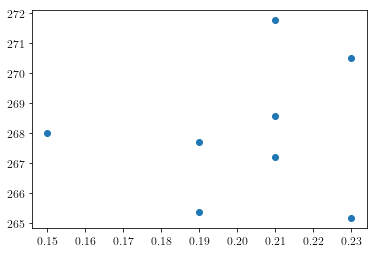

In [1438]:
plt.plot(L_xt_p,m_Rt_p,'o')

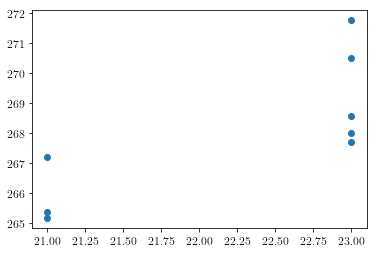

In [1434]:
plt.plot(H_p,m_Rt_p,'o')

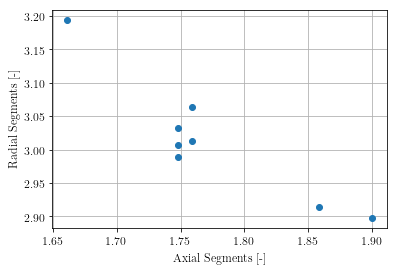

In [1441]:
plt.plot((1+np.array(L_xt_p))*np.array(L_p)/90,(np.array(R4_p) - np.array(R3_p))/55,'o')

plt.grid()
plt.xlabel('Axial Segments [-]')
plt.ylabel('Radial Segments [-]')
#plt.ylim(1100,1300)
#plt.xlim(700,750)
plt.savefig('N_segments.png',format = 'png', dpi=500,bbox_inches='tight')

In [1423]:
Q_c = []
cont = 0

T_c = 22
T_h = 35

Q_c_target = 2800

m_f_target = []
FE_target = []
f_target = []
L_target = []
H_target = []
W_target = []
Tce_target = []
The_target = []
ECr_c = []
ECr_h = []
R4 = []
R3 = []
R2 = []
W_mag = []
W_pump = []
B_target = []
Q_h = []
L_xt_target = []
FL_target = []
dp_target = []
hf_target = []

##Properties of the solid 
rho_s = 7000  #[kg/m3] Density of the solid
k_s   = 8 #[W/(m2.K)] #Thermal conductivity of the solid

## Propertis of the fluid
rho_f = 1000  #[kg/m3] Density of the fluid
c_f   = 4181  #[kJ/(kg.K)] # Specific heat of the fluid
Pr_f  = 6.136 #[-] Prandtl of the fluid
mu_f  = 0.00061 #0.0008901 #[kg/m-2] #Viscosity of the fluid
k_f   = 0.6065  #[W/(m2.K)] #Thermal conductivity of the fluid

## Porous medium


#Magnetic Circuit
B_rem = 1.43
N_p = 2
N_Rp = 2

for i in range(size(FE)):
    for j in range(len(f)):
        for k in range(len(L)):
            for l in range(len(H)):
                for m in range(len(W)):
                    for n in range(len(Tce)):
                        for o in range(len(The)):
                            for p in range(len(B_max)):
                                for q in range(len(L_xt)):
                                    for r in range(len(d_par)):
                                        for s in range(len(h_f)):
                                            it = 0
                                            Q_c_system = 0

                                            d_p = d_par[r] #[m] Particle diameter

                                            Epsilon = 0.5 #0.55  #[-] Porosity
                                            Epsilon_ep = 0.2
                                            Epsilon_dp = Epsilon - Epsilon_ep #0.36 #0.465 #[-] Porosity
                                            d_ph = (2/3)*Epsilon_dp/(1-Epsilon_dp)*d_p #290*10**(-6) #[m] Particle diameter
                                            #h_f = 40

                                            while Q_c_system < Q_c_target and it < len(m_f):
                                                A,B,C,D,E,F,G,A1,A2,A3,A4 = Optimal(m_f[it],FE[i],f[j],L[k],H[l],W[m],B_max[p],T_c+273.15,T_h+273.15,Tce[n]+273.15,The[o]+273.15,L_xt[q],h_f[s])
                                                Q_c_system = A[0]
                                                it = it + 1
                                                #print(A,B,C,D,E,F,G,A1,A2,A3)
                                                #print(m_f[it-1]*3600,Q_c_system )
                                            #print(it,Q_c_system)
                                            if Q_c_system > Q_c_target:
                                                Q_c.append(Q_c_system)
                                                m_f_target.append(3600*m_f[it-1])
                                                FE_target.append(FE[i])
                                                f_target.append(f[j])
                                                L_target.append(L[k])
                                                H_target.append(H[l])
                                                W_target.append(W[m])
                                                Tce_target.append(Tce[n])
                                                The_target.append(The[o])
                                                B_target.append(B_max[p])
                                                dp_target.append(d_p)
                                                hf_target.append(h_f[s])
                                                
                                                
                                                ECr_c.append(B[0])
                                                ECr_h.append(C[0])
                                                R4.append(D[0])
                                                R3.append(E[0])
                                                R2.append(F[0])
                                                W_mag.append(G[0])
                                                W_pump.append(A1)
                                                Q_h.append(A2[0])
                                                L_xt_target.append(A3)
                                                FL_target.append(A4)

                                            cont = cont+1
                                    print(100*cont/(len(FE)*len(f)*len(L)*len(H)*len(W)*len(Tce)*len(The)*len(B_max)*len(L_xt)*len(d_par)*len(h_f)))


0.028935185185185185
0.05787037037037037
0.08680555555555555
0.11574074074074074
0.14467592592592593
0.1736111111111111
0.2025462962962963
0.23148148148148148
0.2604166666666667
0.28935185185185186
0.31828703703703703
0.3472222222222222
0.3761574074074074
0.4050925925925926
0.4340277777777778
0.46296296296296297
0.49189814814814814
0.5208333333333334
0.5497685185185185
0.5787037037037037
0.6076388888888888
0.6365740740740741
0.6655092592592593
0.6944444444444444
0.7233796296296297
0.7523148148148148
0.78125
0.8101851851851852
0.8391203703703703
0.8680555555555556
0.8969907407407407
0.9259259259259259
0.9548611111111112
0.9837962962962963
1.0127314814814814
1.0416666666666667
1.0706018518518519
1.099537037037037
1.1284722222222223
1.1574074074074074
1.1863425925925926
1.2152777777777777
1.244212962962963
1.2731481481481481
1.3020833333333333
1.3310185185185186
1.3599537037037037
1.3888888888888888
1.4178240740740742
1.4467592592592593
1.4756944444444444
1.5046296296296295
1.533564814814

13.45486111111111
13.483796296296296
13.512731481481481
13.541666666666666
13.570601851851851
13.599537037037036
13.628472222222221
13.657407407407407
13.686342592592593
13.715277777777779
13.744212962962964
13.773148148148149
13.802083333333334
13.831018518518519
13.859953703703704
13.88888888888889
13.917824074074074
13.94675925925926
13.975694444444445
14.00462962962963
14.033564814814815
14.0625
14.091435185185185
14.12037037037037
14.149305555555555
14.17824074074074
14.207175925925926
14.23611111111111
14.265046296296296
14.293981481481481
14.322916666666666
14.351851851851851
14.380787037037036
14.409722222222221
14.438657407407407
14.467592592592593
14.496527777777779
14.525462962962964
14.554398148148149
14.583333333333334
14.612268518518519
14.641203703703704
14.67013888888889
14.699074074074074
14.72800925925926
14.756944444444445
14.78587962962963
14.814814814814815
14.84375
14.872685185185185
14.90162037037037
14.930555555555555
14.95949074074074
14.988425925925926
15.0173

26.85185185185185
26.880787037037038
26.90972222222222
26.93865740740741
26.96759259259259
26.99652777777778
27.025462962962962
27.05439814814815
27.083333333333332
27.11226851851852
27.141203703703702
27.17013888888889
27.199074074074073
27.22800925925926
27.256944444444443
27.28587962962963
27.314814814814813
27.34375
27.372685185185187
27.40162037037037
27.430555555555557
27.45949074074074
27.488425925925927
27.51736111111111
27.546296296296298
27.57523148148148
27.604166666666668
27.63310185185185
27.662037037037038
27.69097222222222
27.71990740740741
27.74884259259259
27.77777777777778
27.806712962962962
27.83564814814815
27.864583333333332
27.89351851851852
27.922453703703702
27.95138888888889
27.980324074074073
28.00925925925926
28.038194444444443
28.06712962962963
28.096064814814813
28.125
28.153935185185187
28.18287037037037
28.211805555555557
28.24074074074074
28.269675925925927
28.29861111111111
28.327546296296298
28.35648148148148
28.385416666666668
28.41435185185185
28.443

40.07523148148148
40.104166666666664
40.133101851851855
40.16203703703704
40.19097222222222
40.219907407407405
40.248842592592595
40.27777777777778
40.30671296296296
40.335648148148145
40.364583333333336
40.39351851851852
40.4224537037037
40.451388888888886
40.480324074074076
40.50925925925926
40.53819444444444
40.567129629629626
40.59606481481482
40.625
40.65393518518518
40.682870370370374
40.71180555555556
40.74074074074074
40.769675925925924
40.798611111111114
40.8275462962963
40.85648148148148
40.885416666666664
40.914351851851855
40.94328703703704
40.97222222222222
41.001157407407405
41.030092592592595
41.05902777777778
41.08796296296296
41.116898148148145
41.145833333333336
41.17476851851852
41.2037037037037
41.232638888888886
41.261574074074076
41.29050925925926
41.31944444444444
41.348379629629626
41.37731481481482
41.40625
41.43518518518518
41.464120370370374
41.49305555555556
41.52199074074074
41.550925925925924
41.579861111111114
41.6087962962963
41.63773148148148
41.6666666

55.78703703703704
55.81597222222222
55.844907407407405
55.873842592592595
55.90277777777778
55.93171296296296
55.960648148148145
55.989583333333336
56.01851851851852
56.0474537037037
56.076388888888886
56.105324074074076
56.13425925925926
56.16319444444444
56.192129629629626
56.22106481481482
56.25
56.27893518518518
56.307870370370374
56.33680555555556
56.36574074074074
56.394675925925924
56.423611111111114
56.4525462962963
56.48148148148148
56.510416666666664
56.539351851851855
56.56828703703704
56.59722222222222
56.626157407407405
56.655092592592595
56.68402777777778
56.71296296296296
56.741898148148145
56.770833333333336
56.79976851851852
56.8287037037037
56.857638888888886
56.886574074074076
56.91550925925926
56.94444444444444
56.973379629629626
57.00231481481482
57.03125
57.06018518518518
57.089120370370374
57.11805555555556
57.14699074074074
57.175925925925924
57.204861111111114
57.2337962962963
57.26273148148148
57.291666666666664
57.320601851851855
57.34953703703704
57.37847222

69.58912037037037
69.61805555555556
69.64699074074075
69.67592592592592
69.70486111111111
69.73379629629629
69.76273148148148
69.79166666666667
69.82060185185185
69.84953703703704
69.87847222222223
69.9074074074074
69.9363425925926
69.96527777777777
69.99421296296296
70.02314814814815
70.05208333333333
70.08101851851852
70.10995370370371
70.13888888888889
70.16782407407408
70.19675925925925
70.22569444444444
70.25462962962963
70.28356481481481
70.3125
70.34143518518519
70.37037037037037
70.39930555555556
70.42824074074075
70.45717592592592
70.48611111111111
70.51504629629629
70.54398148148148
70.57291666666667
70.60185185185185
70.63078703703704
70.65972222222223
70.6886574074074
70.7175925925926
70.74652777777777
70.77546296296296
70.80439814814815
70.83333333333333
70.86226851851852
70.89120370370371
70.92013888888889
70.94907407407408
70.97800925925925
71.00694444444444
71.03587962962963
71.06481481481481
71.09375
71.12268518518519
71.15162037037037
71.18055555555556
71.209490740740

83.50694444444444
83.53587962962963
83.56481481481481
83.59375
83.62268518518519
83.65162037037037
83.68055555555556
83.70949074074075
83.73842592592592
83.76736111111111
83.79629629629629
83.82523148148148
83.85416666666667
83.88310185185185
83.91203703703704
83.94097222222223
83.9699074074074
83.9988425925926
84.02777777777777
84.05671296296296
84.08564814814815
84.11458333333333
84.14351851851852
84.17245370370371
84.20138888888889
84.23032407407408
84.25925925925925
84.28819444444444
84.31712962962963
84.34606481481481
84.375
84.40393518518519
84.43287037037037
84.46180555555556
84.49074074074075
84.51967592592592
84.54861111111111
84.57754629629629
84.60648148148148
84.63541666666667
84.66435185185185
84.69328703703704
84.72222222222223
84.7511574074074
84.7800925925926
84.80902777777777
84.83796296296296
84.86689814814815
84.89583333333333
84.92476851851852
84.95370370370371
84.98263888888889
85.01157407407408
85.04050925925925
85.06944444444444
85.09837962962963
85.1273148148148

97.2800925925926
97.30902777777777
97.33796296296296
97.36689814814815
97.39583333333333
97.42476851851852
97.45370370370371
97.48263888888889
97.51157407407408
97.54050925925925
97.56944444444444
97.59837962962963
97.62731481481481
97.65625
97.68518518518519
97.71412037037037
97.74305555555556
97.77199074074075
97.80092592592592
97.82986111111111
97.85879629629629
97.88773148148148
97.91666666666667
97.94560185185185
97.97453703703704
98.00347222222223
98.0324074074074
98.0613425925926
98.09027777777777
98.11921296296296
98.14814814814815
98.17708333333333
98.20601851851852
98.23495370370371
98.26388888888889
98.29282407407408
98.32175925925925
98.35069444444444
98.37962962962963
98.40856481481481
98.4375
98.46643518518519
98.49537037037037
98.52430555555556
98.55324074074075
98.58217592592592
98.61111111111111
98.64004629629629
98.66898148148148
98.69791666666667
98.72685185185185
98.75578703703704
98.78472222222223
98.8136574074074
98.8425925925926
98.87152777777777
98.9004629629629

In [1424]:
N_circ_cold = 7
N_circ_hot = 7

W_FT_c = np.zeros(len(m_f_target))
W_Ff_c = np.zeros(len(m_f_target))
W_Fp_c = np.zeros(len(m_f_target))

W_FT_h = np.zeros(len(m_f_target))
W_Ff_h = np.zeros(len(m_f_target))
W_Fp_h = np.zeros(len(m_f_target))


for i in range(len(m_f_target)):
    print(i/len(m_f_target)*100)
    [W_FT_c[i],W_Ff_c[i],W_Fp_c[i]] = HEx_Power(m_f_HEx_c,W_T_HEx_c,W_f_HEx_c,W_p_HEx_c,Ec_HEx_c,4*m_f_target[i]/N_circ_cold,ECr_c[i])
    [W_FT_h[i],W_Ff_h[i],W_Fp_h[i]] = HEx_Power(m_f_HEx_h,W_T_HEx_h,W_f_HEx_h,W_p_HEx_h,Ec_HEx_h,4*m_f_target[i]/N_circ_hot,ECr_h[i])
    #if W_FT_c[i] == 'Nan':
        #print(4*m_f_target[i]/8,ECr_c[i])
    #if W_FT_c[i] == 'Nan':
        #print(4*m_f_target[i]/8,ECr_h[i])

0.0
0.09842519685039369
0.19685039370078738
0.2952755905511811
0.39370078740157477
0.4921259842519685
0.5905511811023622
0.6889763779527559
0.7874015748031495
0.8858267716535433
0.984251968503937
1.0826771653543308
1.1811023622047243
1.279527559055118
1.3779527559055118
1.4763779527559056
1.574803149606299
1.673228346456693
1.7716535433070866
1.8700787401574805
1.968503937007874
2.066929133858268
2.1653543307086616
2.263779527559055
2.3622047244094486
2.4606299212598426
2.559055118110236
2.65748031496063
2.7559055118110236
2.8543307086614176
2.952755905511811
3.0511811023622046
3.149606299212598
3.2480314960629917
3.346456692913386
3.4448818897637796
3.543307086614173
3.6417322834645667
3.740157480314961
3.8385826771653546
3.937007874015748
4.035433070866142
4.133858267716536
4.23228346456693
4.330708661417323
4.429133858267717
4.52755905511811
4.625984251968504
4.724409448818897
4.822834645669291
4.921259842519685
5.019685039370079
5.118110236220472
5.216535433070866
5.31496062992126


44.78346456692913
44.881889763779526
44.98031496062992
45.07874015748031
45.177165354330704
45.2755905511811
45.374015748031496
45.47244094488189
45.57086614173229
45.66929133858268
45.767716535433074
45.86614173228347
45.96456692913386
46.06299212598425
46.161417322834644
46.25984251968504
46.35826771653544
46.45669291338583
46.55511811023622
46.653543307086615
46.75196850393701
46.8503937007874
46.94881889763779
47.047244094488185
47.145669291338585
47.24409448818898
47.34251968503937
47.44094488188976
47.539370078740156
47.63779527559055
47.73622047244094
47.83464566929133
47.93307086614173
48.031496062992126
48.12992125984252
48.22834645669291
48.326771653543304
48.4251968503937
48.523622047244096
48.62204724409449
48.72047244094488
48.818897637795274
48.917322834645674
49.01574803149607
49.11417322834646
49.21259842519685
49.311023622047244
49.40944881889764
49.50787401574803
49.60629921259843
49.70472440944882
49.803149606299215
49.90157480314961
50.0
50.09842519685039
50.1968503

90.45275590551181
90.5511811023622
90.6496062992126
90.74803149606299
90.84645669291339
90.94488188976378
91.04330708661418
91.14173228346458
91.24015748031496
91.33858267716536
91.43700787401575
91.53543307086615
91.63385826771653
91.73228346456693
91.83070866141733
91.92913385826772
92.02755905511812
92.1259842519685
92.2244094488189
92.32283464566929
92.42125984251969
92.51968503937007
92.61811023622047
92.71653543307087
92.81496062992126
92.91338582677166
93.01181102362204
93.11023622047244
93.20866141732283
93.30708661417323
93.40551181102363
93.50393700787401
93.60236220472441
93.7007874015748
93.7992125984252
93.89763779527559
93.99606299212599
94.09448818897637
94.19291338582677
94.29133858267717
94.38976377952756
94.48818897637796
94.58661417322834
94.68503937007874
94.78346456692913
94.88188976377953
94.98031496062993
95.07874015748031
95.17716535433071
95.2755905511811
95.3740157480315
95.47244094488188
95.57086614173228
95.66929133858267
95.76771653543307
95.86614173228347


In [1425]:
W_p_valve = (2*np.array(m_f_target)/4/1000)**2*10**5**(2*np.array(m_f_target)/3600)/1000*4/np.array(FE_target)
W_valve   = 8*16

In [1426]:
t_h = 4
t_w = 2.5

m_La = (np.pi*((np.array(R3)-t_h)**2-(np.array(R2)+t_h)**2)- 16*(2*t_w)*((np.array(R3)-t_h)-(np.array(R2)+t_h)))*np.array(L_target)*(1-Epsilon)*7000*10**-9
m_Rt = np.pi*((np.array(R4))**2-np.array(R3)**2)*10**-6*((1+np.array(L_xt_target))*np.array(L_target)/1000)*7500 #25**2
m_St = np.pi*((np.array(R2)**2))*10**-6*((1+np.array(L_xt_target))*np.array(L_target)/1000)*7500
m_Fe = np.pi*((np.array(R4)+hf_target)**2-np.array(R4)**2)*10**-6*((1+np.array(L_xt_target))*np.array(L_target)/1000)*7500 #25**2
m_Nd = m_Rt + m_St + m_Fe
m_w  = (4/np.array(FE_target)*np.array(H_target)*np.array(W_target)*np.array(L_target)*(Epsilon_dp)*1000*10**-9)

In [1427]:
m_T = m_La + m_Rt + m_St + m_Fe + m_w
W_T = W_Ff_c + W_Ff_h + W_Fp_c + W_Fp_h +np.array(W_mag)*16 + np.array(W_pump)*16+ W_valve + W_p_valve

In [1428]:
m_p = []
W_pa =[]

m_Nd_p = []
m_Rt_p = []
m_La_p = []
m_w_p = []

W_p_CHEx_p = []
W_p_CHEx_f = []
W_p_HHEx_p = []
W_p_HHEx_f = []
W_p_mag = []
W_p_pump = []
W_pa_valve = []
W_pa_p_valve = []


m_f_p = []
FE_p  =[]
f_p = []
L_p = []
H_p = []
W_p = []
B_max_p = []
Tce_p = []
The_p = []
dp_p = []
ECrc_p = []
ECrh_p = []
Qh_p = []

R2_p = []
R3_p = []
R4_p = []
hf_p = []
L_xt_p = []


for i in range(len(m_T)):
    print(i/len(m_T))
    A = 0
    for j in  range(len(m_T)):
        #if (m_T[i] >= m_T[j] and W_T[i] > W_T[j]) or (m_T[i] > m_T[j] and W_T[i] >= W_T[j]):
        if (m_Rt[i] >= m_Rt[j] and W_T[i] > W_T[j]) or (m_Rt[i] > m_Rt[j] and W_T[i] >= W_T[j]):
            A = 1
    if A == 0 :
        #print(m_T[i],W_T[i])
        m_p.append(m_T[i])
        m_Nd_p.append(m_Nd[i])
        m_Rt_p.append(m_Rt[i])
        m_La_p.append(m_La[i])
        m_w_p.append(m_w[i])
        
        m_f_p.append(m_f_target[i])
        FE_p.append(FE_target[i])
        f_p.append(f_target[i])
        L_p.append(L_target[i])
        H_p.append(H_target[i])
        W_p.append(W_target[i])
        B_max_p.append(B_target[i])
        Tce_p.append(Tce_target[i])
        The_p.append(The_target[i])
        dp_p.append(dp_target[i])
        
        ECrc_p.append(ECr_c[i])
        ECrh_p.append(ECr_h[i])
        Qh_p.append(Q_h[i])
        
        R2_p.append(R2[i])
        R3_p.append(R3[i])
        R4_p.append(R4[i])
        L_xt_p.append(L_xt_target[i])
        hf_p.append(hf_target[i])
        #A = Optimal(m_f_target[i]/3600,FE_target[i],f_target[i],L_target[i],H_target[i],W_target[i],B_target[i],T_c+273.15,T_h+273.15,Tce_target[i]+273.15,The_target[i]+273.15,L_xt_target[i])
        #print(A[0],m_f_target[i],FE_target[i],f_target[i],L_target[i],H_target[i],W_target[i],B_target[i],T_c+273.15,T_h+273.15,Tce_target[i]+273.15,The_target[i]+273.15,L_xt_target[i])
        
        W_pa.append(W_T[i])
        W_p_CHEx_p.append(W_Fp_c[i])
        W_p_CHEx_f.append(W_Ff_c[i])
        W_p_HHEx_p.append(W_Fp_h[i])
        W_p_HHEx_f.append(W_Ff_h[i])
        W_p_mag.append(np.array(W_mag[i])*4/np.array(FE_target[i]))
        W_p_pump.append(np.array(W_pump[i])*4/np.array(FE_target[i]))
        W_pa_valve.append(W_valve)
        W_pa_p_valve.append(W_p_valve[i])   

0.0
0.000984251968503937
0.001968503937007874
0.002952755905511811
0.003937007874015748
0.004921259842519685
0.005905511811023622
0.006889763779527559
0.007874015748031496
0.008858267716535433
0.00984251968503937
0.010826771653543307
0.011811023622047244
0.012795275590551181
0.013779527559055118
0.014763779527559055
0.015748031496062992
0.01673228346456693
0.017716535433070866
0.018700787401574805
0.01968503937007874
0.02066929133858268
0.021653543307086614
0.022637795275590553
0.023622047244094488
0.024606299212598427
0.025590551181102362
0.0265748031496063
0.027559055118110236
0.028543307086614175
0.02952755905511811
0.03051181102362205
0.031496062992125984
0.03248031496062992
0.03346456692913386
0.0344488188976378
0.03543307086614173
0.03641732283464567
0.03740157480314961
0.038385826771653545
0.03937007874015748
0.040354330708661415
0.04133858267716536
0.04232283464566929
0.04330708661417323
0.04429133858267716
0.045275590551181105
0.04625984251968504
0.047244094488188976
0.0482283

0.5679133858267716
0.5688976377952756
0.5698818897637795
0.5708661417322834
0.5718503937007874
0.5728346456692913
0.5738188976377953
0.5748031496062992
0.5757874015748031
0.5767716535433071
0.577755905511811
0.5787401574803149
0.5797244094488189
0.5807086614173228
0.5816929133858267
0.5826771653543307
0.5836614173228346
0.5846456692913385
0.5856299212598425
0.5866141732283464
0.5875984251968503
0.5885826771653543
0.5895669291338582
0.5905511811023622
0.5915354330708661
0.59251968503937
0.593503937007874
0.594488188976378
0.5954724409448819
0.5964566929133859
0.5974409448818898
0.5984251968503937
0.5994094488188977
0.6003937007874016
0.6013779527559056
0.6023622047244095
0.6033464566929134
0.6043307086614174
0.6053149606299213
0.6062992125984252
0.6072834645669292
0.6082677165354331
0.609251968503937
0.610236220472441
0.6112204724409449
0.6122047244094488
0.6131889763779528
0.6141732283464567
0.6151574803149606
0.6161417322834646
0.6171259842519685
0.6181102362204725
0.6190944881889764


In [1429]:
workbook = xlsxwriter.Workbook('Optimization_Rotor.xlsx')
Data = workbook.add_worksheet('Data')

for i in range(len(m_f_p)):
    Data.write(i,0,m_f_p[i]) 
    Data.write(i,1,FE_p[i])
    Data.write(i,2,f_p[i])
    Data.write(i,3,L_p[i])
    Data.write(i,4,H_p[i])
    Data.write(i,5,W_p[i]) 
    Data.write(i,6,B_max_p[i])
    Data.write(i,7,Tce_p[i])
    Data.write(i,8,The_p[i])
    Data.write(i,9,m_p[i])
    Data.write(i,10,m_Nd_p[i])
    Data.write(i,11,m_La_p[i])
    Data.write(i,12,m_w_p[i])
    Data.write(i,13,W_pa[i])
    Data.write(i,14,W_p_CHEx_p[i])
    Data.write(i,15,W_p_CHEx_f[i])
    Data.write(i,16,W_p_HHEx_p[i])
    Data.write(i,17,W_p_HHEx_f[i])
    Data.write(i,18,W_p_mag[i])
    Data.write(i,19,W_p_pump[i])
    Data.write(i,20,R2_p[i])
    Data.write(i,21,R3_p[i])
    Data.write(i,22,R4_p[i])
    Data.write(i,23,L_xt_p[i])
    Data.write(i,24,hf_p[i])
    Data.write(i,25,ECrc_p[i])
    Data.write(i,26,ECrh_p[i])
    Data.write(i,27,Qh_p[i])
    Data.write(i,28,m_Rt_p[i])
    
workbook.close()

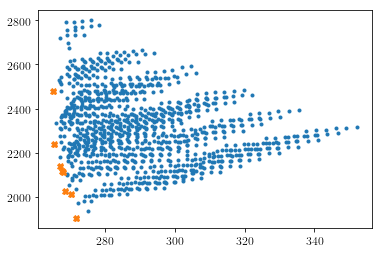

In [1430]:
plt.plot(m_Rt,W_T,'.')
plt.plot(m_Rt_p,W_pa,'X')

In [1431]:
m_3 = m_Rt_p
W_3 = W_pa

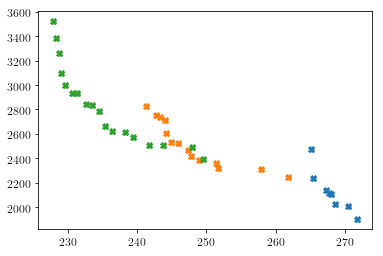

In [1432]:
plt.plot(m_3,W_3,'X')
plt.plot(m_4,W_4,'X')
plt.plot(m_5,W_5,'X')

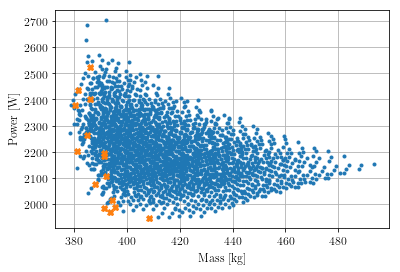

In [1232]:
plt.plot(m_T,W_T,'.')
plt.plot(m_p,W_pa,'X')
plt.grid()
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
#plt.ylim(1100,1300)
#plt.xlim(700,750)
plt.savefig('Optimum_Rotor.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
#plt.plot(m_T,m_La,'.')
plt.plot(R3_p,m_p,'X')

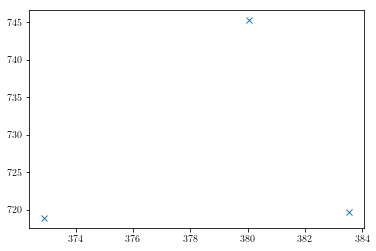

In [852]:
plt.plot(R4_p,m_p,'x')

In [919]:
Q_c_new = [[] for i in range(len(m_p))]
m_flow_new = [[] for i in range(len(m_p))]


for i in range(len(m_p)):
    m_flow = np.arange(m_f_p[i]+5,1200,5)
    #print(m_f_p[i])
    for j in range(len(m_flow)):
        A = Optimal(m_flow[j]/3600,FE_p[i],f_p[i],L_p[i],H_p[i],W_p[i],B_max_p[i],22+273.15,35+273.15,Tce_p[i]+273.15,The_p[i]+273.15,L_xt_p[i],hf_p[i])
        #print(m_flow[j],A[0],i,j,FE_p[i],f_p[i],L_p[i],H_p[i],W_p[i],B_max_p[i],22+273.15,35+273.15,Tce_p[i],The_p[i],L_xt_p[i])
        Q_c_new[i].append(A[0])
        m_flow_new[i].append(m_flow[j])

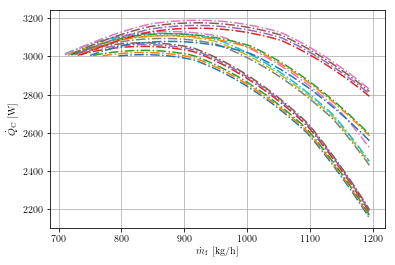

In [920]:
for i in range(len(m_p)):
    plt.plot(m_flow_new[i],Q_c_new[i],'-.')
#plt.ylim(2900,4700)
plt.grid()
#plt.legend()
plt.xlabel(r'$\dot{m}_\mathrm{f}$ [kg/h]')
plt.ylabel(r'$\dot{Q}_\mathrm{C}$ [W]')
plt.savefig('Extra.png',format = 'png', dpi=1000,bbox_inches='tight')

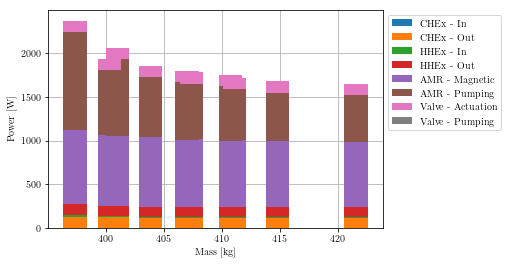

In [636]:
width = 2
plt.grid(zorder = 0)
plt.bar(m_p,W_p_CHEx_p, width, label = 'CHEx - In',zorder = 3)
plt.bar(m_p,W_p_HHEx_f, width, bottom = W_p_CHEx_p, label = 'CHEx - Out',zorder = 3)
plt.bar(m_p,W_p_HHEx_p, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f), label = 'HHEx - In',zorder = 3)
plt.bar(m_p,W_p_HHEx_f, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p), label = 'HHEx - Out',zorder = 3)
plt.bar(m_p,W_p_mag, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f), label = 'AMR - Magnetic',zorder = 3)
plt.bar(m_p,W_p_pump, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f)+ np.array(W_p_mag) , label = 'AMR - Pumping',zorder = 3)
plt.bar(m_p,W_pa_valve, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f) + np.array(W_p_mag) + np.array(W_p_pump) , label = 'Valve - Actuation',zorder = 3)
plt.bar(m_p,W_pa_p_valve, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f)+ np.array(W_p_mag) + np.array(W_p_pump)+ np.array(W_pa_valve), label = 'Valve - Pumping',zorder = 3)

#plt.xlim([575,865])
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
plt.legend(bbox_to_anchor = (1,1))
plt.savefig('Power_Breakdown.png',format = 'png', dpi=500,bbox_inches='tight')

In [637]:
m_La_p = np.pi*(np.array(R3_p)**2-np.array(R2_p)**2)*np.array(L_p)*(1-Epsilon)*7000*10**-9
m_Rt_p = np.pi*((np.array(R4_p))**2-np.array(R3_p)**2)*10**-6*((1+np.array(L_xt_p))*np.array(L_p)/1000)*7500 #25**2
m_St_p = np.pi*((np.array(R2_p)**2))*10**-6*((1+np.array(L_xt_p))*np.array(L_p)/1000)*7500
m_Fe_p = np.pi*((np.array(R4_p)+np.array(hf_p))**2-np.array(R4_p)**2)*10**-6*((1+np.array(L_xt_p))*np.array(L_p)/1000)*7500 #25**2 


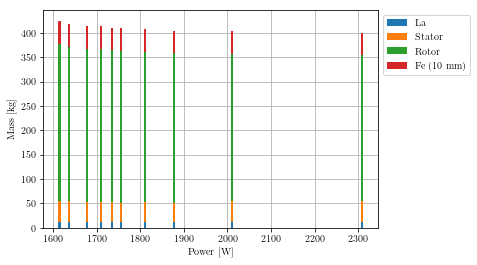

In [638]:
width = 5
plt.grid(zorder = 0)
plt.bar(W_pa,m_La_p, width, label = 'La',zorder = 3)
plt.bar(W_pa,m_St_p, width,bottom = m_La_p, label = 'Stator',zorder = 3)
plt.bar(W_pa,m_Rt_p, width,bottom = np.array(m_La_p) + np.array(m_St_p), label = 'Rotor',zorder = 3)
plt.bar(W_pa,m_Fe_p, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p), label = 'Fe (10 mm)',zorder = 3)
#plt.bar(W_pa,m_Fe_p_80, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p)+ np.array(m_Fe_p_10)+ np.array(m_Fe_p_20)+ np.array(m_Fe_p_40), label = 'Fe (80 mm)',zorder = 3)
plt.legend( bbox_to_anchor=[1, 1])
plt.ylabel('Mass [kg]')
plt.xlabel('Power [W]')
#plt.xlim(870,1300)
#plt.ylim(0,1050)
plt.savefig('Mass_Breakdown.png',format = 'png', dpi=500,bbox_inches='tight')